In [93]:
# imported all the required libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch 
import torch.nn as nn
import torch.nn.functional as F
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from string import punctuation
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import pickle

#### Data Loading

In [80]:
# This file contains the DTDC courier customer complaints 
data = pd.read_excel('DTDC_Complaints_Dataset.xlsx')
data.head(10)

,Complaint Text,Category
0,Support team ignored my issue.,Service Quality Issue
1,Wrong address printed.,Booking Issue
2,Delivery attempt was not made.,Failed Delivery
3,App crashes during booking.,Booking Issue
4,Repeated failed delivery attempts without cont...,Failed Delivery
5,Support promised a call back that never came.,Customer Service
6,Took more than 10 days to deliver.,Delivery Delay
7,Support promised a call back that never came.,Customer Service
8,Electronics arrived damaged.,Damaged Parcel
9,The shipment was held at the local office for ...,Delivery Delay


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Complaint Text  3500 non-null   object
 1   Category        3500 non-null   object
dtypes: object(2)
memory usage: 54.8+ KB


In [82]:
data['Category'].value_counts()

Category
Service Quality Issue    381
Tracking Issue           368
Booking Issue            351
Customer Service         351
Delivery Delay           351
Failed Delivery          350
Overcharging             349
Damaged Parcel           333
Wrong Delivery           333
Misplaced Parcel         333
Name: count, dtype: int64

In [83]:
data['Category'].value_counts().to_numpy().mean()

350.0

#### Text Processing

The text processing steps I took are 
1. Removing punctuations from the text.
2. Tokenizing the sentences into words.
3. Removing stopwords.
4. Performing Lemmatization

In [ ]:
# Here all the preprocessing is done
def data_preprocessing(text):
    text = "".join([char for char in text if char not in punctuation])
    text = re.split(" ", text.lower())
    text = [word for word in text if word not in stopwords.words('english')]
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    return text

In [85]:
# Here I took the column in which all the data was cleaned and tokenized
data['Cleaned_Complaint_text'] = data['Complaint Text'].apply(lambda x : data_preprocessing(x))

In [86]:
# here I extracted all unique words from the complaint sentences
sentences = data['Cleaned_Complaint_text']
vocabulary = []
for sentence in sentences:
    vocabulary.extend(sentence)
vocabulary = list(set(vocabulary))

In [89]:
vocabulary

['meant',
 'cooperative',
 'went',
 'note',
 'know',
 'content',
 'issue',
 'delivered',
 'internal',
 'despite',
 'explanation',
 'take',
 'invoice',
 'unprofessional',
 'checkout',
 'card',
 'product',
 'seal',
 'one',
 'doesnt',
 'street',
 'updated',
 'size',
 'week',
 'returned',
 'match',
 'time',
 'receiver',
 'simple',
 'different',
 'charge',
 'arrive',
 'booking',
 'caused',
 'pin',
 'arrived',
 'multiple',
 'unavailable',
 'shattered',
 'agent',
 'help',
 'payment',
 'never',
 'rude',
 'tracking',
 'haven’t',
 'lost',
 'later',
 'contacting',
 'applied',
 'courier',
 'local',
 'back',
 'held',
 'arrival',
 'info',
 'handled',
 'app',
 'customer',
 'complaint',
 'glass',
 'assistance',
 'crashing',
 'false',
 'parcel',
 'estimated',
 'consignment',
 'team',
 'detail',
 'got',
 'transfer',
 'followup',
 'shop',
 'missing',
 'citing',
 'still',
 'vague',
 'upon',
 'respond',
 'spoiled',
 'keep',
 'wearing',
 'midtransit',
 'online',
 'item',
 'dtdc',
 'business',
 'confirmation

In [90]:
data

,Complaint Text,Category,Cleaned_Complaint_text
0,Support team ignored my issue.,Service Quality Issue,"[support, team, ignored, issue]"
1,Wrong address printed.,Booking Issue,"[wrong, address, printed]"
2,Delivery attempt was not made.,Failed Delivery,"[delivery, attempt, made]"
3,App crashes during booking.,Booking Issue,"[app, crash, booking]"
4,Repeated failed delivery attempts without cont...,Failed Delivery,"[repeated, failed, delivery, attempt, without,..."
...,...,...,...
3495,DTDC team never picked up the parcel as schedu...,Service Quality Issue,"[dtdc, team, never, picked, parcel, scheduled]"
3496,"Tracking shows delivered, but I haven’t receiv...",Tracking Issue,"[tracking, show, delivered, haven’t, received]"
3497,No one knows where my item is.,Misplaced Parcel,"[one, know, item]"
3498,Incorrect invoice amount.,Overcharging,"[incorrect, invoice, amount]"


In [91]:
# here also added the noise so that the model generalizes well
def add_text_noise(tokenized_text, noise_rate=0.1):
    noisy_text = []
    for word in tokenized_text:
        if random.random() < noise_rate:
            if len(word) > 1:
                idx = random.randint(0, len(word) - 1)
                ch = random.choice('abcdefghijklmnopqrstuvwxyz')
                noisy_word = word[:idx] + ch + word[idx+1:]
                noisy_text.append(noisy_word)
            else:
                noisy_text.append(word)
        else:
            noisy_text.append(word)
    return noisy_text


In [92]:
data['Noisy_Complaint_Text'] = data['Cleaned_Complaint_text'].apply(lambda x: add_text_noise(x, noise_rate=0.05))

Feature Engineering

In [ ]:
# length of characters in a sentence is returned here 
def len_of_text(text):
    return len("".join(text.split()))

In [ ]:
data['text_len'] = data['Complaint Text'].apply(lambda x: len("".join(x.split())))

In [ ]:
# Here the punctuations percentage is returned
def Punc_per(text):
    count = sum([1 for char in text if char in punctuation])
    return round(count/(len(text)-text.count(" "))*100,3)

In [16]:
data['punctuation_percent'] = data['Complaint Text'].apply(lambda x : Punc_per(x))

In [17]:
data[['Cleaned_Complaint_text', 'text_len', 'Noisy_Complaint_Text', 'punctuation_percent']]

,Cleaned_Complaint_text,text_len,Noisy_Complaint_Text,punctuation_percent
0,"[support, team, ignored, issue]",26,"[support, team, ignored, issue]",3.846
1,"[wrong, address, printed]",20,"[wrong, address, printed]",5.000
2,"[delivery, attempt, made]",26,"[delivery, attempt, made]",3.846
3,"[app, crash, booking]",24,"[app, craeh, booking]",4.167
4,"[repeated, failed, delivery, attempt, without,...",50,"[repeated, failed, delivery, attempt, without,...",2.000
...,...,...,...,...
3495,"[dtdc, team, never, picked, parcel, scheduled]",42,"[dtdc, team, never, picked, parcel, scheduled]",2.381
3496,"[tracking, show, delivered, haven’t, received]",45,"[tracking, show, delivered, haven’t, received]",4.444
3497,"[one, know, item]",24,"[one, know, item]",4.167
3498,"[incorrect, invoice, amount]",23,"[incorrect, invoice, amount]",4.348


In [18]:
data['Cleaned_Complaint_text'][0]

['support', 'team', 'ignored', 'issue']

In [19]:
data['Complaint Text'][0]

'Support team ignored my issue.'

In [ ]:
# I used the word2vec to get the embeddings of the words in sentences
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
sentences = data['Noisy_Complaint_Text']
w2v_model = Word2Vec(sentences,
                     vector_size=100, 
                     window=5, 
                     min_count=1, 
                     sg=1, 
                     seed=SEED, 
                     workers=1, 
                     epochs=10, 
                     sorted_vocab=True)

In [ ]:
# This is the embedding of the consignment word
print(w2v_model.wv['consignment'])

[-0.13211599  0.12182502 -0.0122977  -0.09803324 -0.4417625   0.03205356
  0.26176235  0.15781341 -0.40905967  0.35100776 -0.27051407 -0.04222998
  0.03172775  0.4141328  -0.20772408 -0.1490182  -0.010878   -0.1729818
 -0.29598233  0.1162228   0.15291026  0.13240549  0.24334155  0.01203908
  0.22784552 -0.14239866 -0.26777703  0.07573591  0.05711015 -0.4466444
  0.22591081 -0.2230867   0.26363158  0.2686042  -0.08258406  0.10372511
 -0.11284307 -0.6113268   0.43200865  0.12419911  0.05304056 -0.1323073
 -0.10209531  0.11603491  0.22259611  0.18842039  0.0881746   0.00221411
  0.02034585 -0.13050325 -0.13479033 -0.45517096  0.19360882  0.13689038
  0.18522793  0.05405187  0.1562037   0.09090196  0.05444345  0.04239547
 -0.35209522  0.08881672 -0.16919492  0.06074291  0.46934348  0.11243263
  0.17508176 -0.0732392  -0.01414083  0.0750332  -0.0830945  -0.13593878
 -0.24869168  0.15384081 -0.16844763  0.11525465 -0.3476928   0.13898945
  0.13624999 -0.03647316 -0.11056267 -0.01655063  0.13

In [ ]:
# Here I considered padding so that all embeddings have same length
embedding_dim = 100
max_len = 10

def get_embedding_matrix(sentences, model, max_len):
    data = []
    for sent in sentences:
        vecs = []
        for word in sent:
            if word in model.wv:
                vecs.append(torch.tensor(model.wv[word]))
        if len(vecs) < max_len:
            pad_len = max_len - len(vecs)
            vecs.extend([torch.zeros(embedding_dim)] * pad_len)
        else:
            vecs = vecs[:max_len]
        data.append(torch.stack(vecs))
    return torch.stack(data)

#### Feed Farword Network

In [ ]:
# Here I took the variable X and stored the padded embeddings
X = get_embedding_matrix(sentences, w2v_model, max_len)
print(X.shape)

torch.Size([3500, 10, 100])


In [ ]:
# Since the normal feed forward network cant analyze the 
X = X.view(X.size(0), -1)
X.shape

torch.Size([3500, 1000])

In [25]:
encoder = LabelEncoder()
def add_label_noise(labels, noise_rate=0.1):
    labels = labels.copy()
    unique_labels = labels.unique()
    for i in range(len(labels)):
        if random.random() < noise_rate:
            labels.iloc[i] = random.choice(unique_labels)
    return labels
data['Noisy_Category'] = add_label_noise(data['Category'], noise_rate=0.1)
y=encoder.fit_transform(data['Noisy_Category'])

In [26]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['text_len', 'punctuation_percent']])
X_scalar = torch.tensor(scaled_features, dtype=torch.float32)

In [27]:
X_ffnn = torch.cat([X, X_scalar], dim=1)
y_ffnn = y

In [28]:
X_ffnn.shape

torch.Size([3500, 1002])

In [29]:
X_ffnn_train, X_ffnn_val, y_ffnn_train, y_ffnn_val = train_test_split(
    X_ffnn, y_ffnn, test_size=0.2, random_state=42
)

In [30]:
class ComplaintDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds_ffnn = ComplaintDataset(X_ffnn_train, torch.tensor(y_ffnn_train, dtype=torch.long))
val_ds_ffnn = ComplaintDataset(X_ffnn_val, torch.tensor(y_ffnn_val, dtype=torch.long))

In [31]:
train_loader_ffnn = DataLoader(train_ds_ffnn, batch_size=32, shuffle=True)
val_loader_ffnn = DataLoader(val_ds_ffnn, batch_size=32)

In [32]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedForwardNet, self).__init__()
        self.output_layer = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.output_layer(x)

In [33]:
model_ffnn = FeedForwardNet(input_dim=X_ffnn.shape[1], output_dim=len(set(y_ffnn)))

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ffnn.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.5,
                                                       patience=2,)

In [35]:
train_losses = []
val_losses = []

for epoch in range(10):
    # Training phase
    model_ffnn.train()
    running_loss = 0.0
    train_preds_all = []
    train_labels_all = []
    
    for batch_X, batch_y in train_loader_ffnn:
        preds = model_ffnn(batch_X)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_preds_all.extend(torch.argmax(preds, dim=1).cpu().numpy())
        train_labels_all.extend(batch_y.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader_ffnn)
    model_ffnn.eval()
    val_loss = 0.0
    val_preds_all = []
    val_labels_all = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader_ffnn:
            preds = model_ffnn(batch_X)
            loss = criterion(preds, batch_y)
            val_loss += loss.item()
            val_preds_all.extend(torch.argmax(preds, dim=1).cpu().numpy())
            val_labels_all.extend(batch_y.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader_ffnn)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1 | Train Loss: 1.8017 | Val Loss: 1.3887
Epoch 2 | Train Loss: 1.2447 | Val Loss: 1.0616
Epoch 3 | Train Loss: 1.0150 | Val Loss: 0.9202
Epoch 4 | Train Loss: 0.8957 | Val Loss: 0.8361
Epoch 5 | Train Loss: 0.8200 | Val Loss: 0.7890
Epoch 6 | Train Loss: 0.7693 | Val Loss: 0.7575
Epoch 7 | Train Loss: 0.7302 | Val Loss: 0.7314
Epoch 8 | Train Loss: 0.7000 | Val Loss: 0.7137
Epoch 9 | Train Loss: 0.6740 | Val Loss: 0.7036
Epoch 10 | Train Loss: 0.6598 | Val Loss: 0.6928


In [36]:
model_ffnn.eval()
with torch.no_grad():
    preds = model_ffnn(X_ffnn_val)
    predicted_labels = torch.argmax(preds, dim=1)


In [54]:
y_true = y_ffnn_val
y_pred = predicted_labels.numpy()

print("Accuracy:", round(accuracy_score(y_true, y_pred), 2))

Accuracy: 0.89


In [55]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred))
print("-"*110)
print("Confusion Matrix\n")
print(confusion_matrix(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94        72
           1       0.89      0.85      0.87        68
           2       0.86      0.85      0.85        66
           3       0.94      0.90      0.92        71
           4       0.87      0.85      0.86        71
           5       0.80      0.91      0.85        67
           6       0.96      0.92      0.94        92
           7       0.88      0.87      0.87        68
           8       0.86      0.94      0.90        65
           9       0.88      0.87      0.87        60

    accuracy                           0.89       700
   macro avg       0.89      0.89      0.89       700
weighted avg       0.89      0.89      0.89       700

--------------------------------------------------------------------------------------------------------------
Confusion Matrix

[[67  0  0  1  2  1  0  1  0  0]
 [ 0 58  2  2  3  2  0  0  1  0]
 [ 1  1 56  0  0  2  0

In [94]:
with open('model_ffnn.pkl', 'wb') as f:
    pickle.dump(model_ffnn.state_dict(), f)

In [38]:
data['Complaint Text'].value_counts()

Complaint Text
Payment went through but no confirmation.                       61
Support didn’t help at all.                                     61
Incorrect invoice amount.                                       60
No one came for pickup.                                         60
Delivery attempt was not made.                                  59
                                                                ..
The package arrived crushed and the contents were broken.        1
shipment was received to the misplaced address.                  1
My DTDC parcel was not handed over on time as promised.          1
item was delivered to the wrong address.                         1
DTDC package was arrived but some items were missing inside.     1
Name: count, Length: 159, dtype: int64

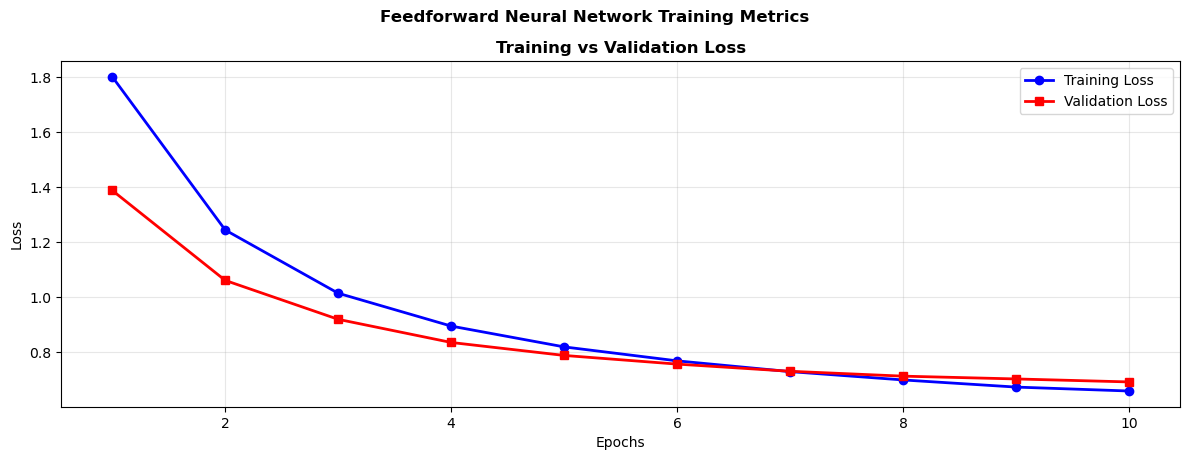

In [74]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
plt.title('Training vs Validation Loss', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Feedforward Neural Network Training Metrics', fontweight='bold', y=1.02)
plt.show()


#### Long-Short term memory

In [40]:
x_lstm = get_embedding_matrix(sentences, w2v_model, max_len)
print(x_lstm.shape)

torch.Size([3500, 10, 100])


In [41]:
y_lstm = torch.tensor(y, dtype=torch.long)

In [42]:
x_lstm_train, x_lstm_val, y_lstm_train, y_lstm_val = train_test_split(
    x_lstm, y_lstm, test_size=0.2, random_state=42
)

In [43]:
class ComplaintDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds_lstm = ComplaintDataset(x_lstm_train, y_lstm_train)
val_ds_lstm = ComplaintDataset(x_lstm_val, y_lstm_val)

train_loader_lstm = DataLoader(train_ds_lstm, batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(val_ds_lstm, batch_size=32)


In [44]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.dropout(hidden[-1])
        return self.fc(out)

In [45]:
model_lstm = LSTMClassifier(input_dim=x_lstm.shape[2], hidden_dim=128, output_dim=len(torch.unique(y_lstm)))

In [46]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [47]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Instantiate Model ===
lstm_model_exp = LSTMClassifier(
    input_dim=x_lstm.shape[2],
    hidden_dim=128,
    output_dim=len(torch.unique(y_lstm))
)
lstm_model_exp.to(device)

# === Loss and Optimizer (No Class Weights) ===
loss_fn_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(lstm_model_exp.parameters(), lr=1e-3)

# === Training Setup ===
num_epochs_lstm = 10
lstm_train_loss_list = []
lstm_val_loss_list = []
lowest_val_loss = float('inf')

for ep in range(num_epochs_lstm):
    # --- Training Phase ---
    lstm_model_exp.train()
    total_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for xb, yb in train_loader_lstm:
        xb, yb = xb.to(device).float(), yb.to(device)

        optimizer_lstm.zero_grad()
        logits = lstm_model_exp(xb)
        loss = loss_fn_lstm(logits, yb)
        loss.backward()
        optimizer_lstm.step()

        total_train_loss += loss.item()
        all_train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_train_labels.extend(yb.cpu().numpy())

    avg_lstm_train_loss = total_train_loss / len(train_loader_lstm)
    lstm_train_loss_list.append(avg_lstm_train_loss)

    # --- Validation Phase ---
    lstm_model_exp.eval()
    total_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for xb, yb in val_loader_lstm:
            xb, yb = xb.to(device).float(), yb.to(device)
            logits = lstm_model_exp(xb)
            loss = loss_fn_lstm(logits, yb)
            total_val_loss += loss.item()

            all_val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_val_labels.extend(yb.cpu().numpy())

    avg_lstm_val_loss = total_val_loss / len(val_loader_lstm)
    lstm_val_loss_list.append(avg_lstm_val_loss)

    print(f"Epoch {ep+1} | Train Loss: {avg_lstm_train_loss:.4f} | Val Loss: {avg_lstm_val_loss:.4f}")

    # Save best model
    if avg_lstm_val_loss < lowest_val_loss:
        lowest_val_loss = avg_lstm_val_loss
        torch.save(lstm_model_exp.state_dict(), "best_lstm_model.pth")

Epoch 1 | Train Loss: 1.9546 | Val Loss: 1.3993
Epoch 2 | Train Loss: 1.2782 | Val Loss: 0.9950
Epoch 3 | Train Loss: 0.9220 | Val Loss: 0.7799
Epoch 4 | Train Loss: 0.7871 | Val Loss: 0.7140
Epoch 5 | Train Loss: 0.6977 | Val Loss: 0.6718
Epoch 6 | Train Loss: 0.6857 | Val Loss: 0.6740
Epoch 7 | Train Loss: 0.6563 | Val Loss: 0.7555
Epoch 8 | Train Loss: 0.6418 | Val Loss: 0.6380
Epoch 9 | Train Loss: 0.6173 | Val Loss: 0.6301
Epoch 10 | Train Loss: 0.5934 | Val Loss: 0.6413


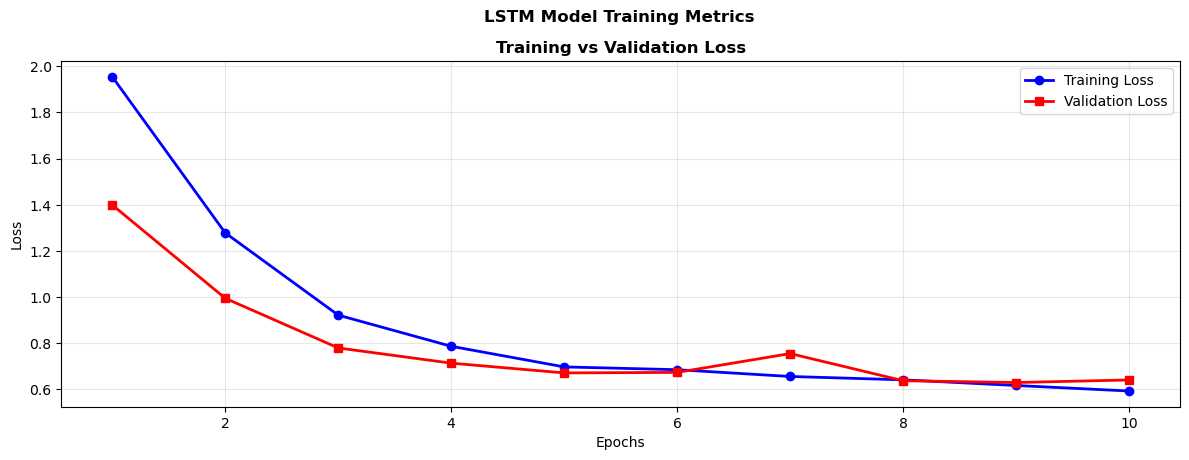

In [73]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)

epochs_range = range(1, len(lstm_train_loss_list) + 1)
plt.plot(epochs_range, lstm_train_loss_list, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs_range, lstm_val_loss_list, 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.title('Training vs Validation Loss', fontweight='bold', x=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('LSTM Model Training Metrics', fontweight='bold', x=0.52, y=1.02)
plt.show()

In [56]:
model_lstm.load_state_dict(torch.load("best_lstm_model.pth"))
model_lstm.eval()

preds, labels = [], []
with torch.no_grad():
    for X, y in val_loader_lstm:
        X, y = X.to(device).float(), y.to(device)
        out = model_lstm(X)
        preds += torch.argmax(out, 1).cpu().tolist()
        labels += y.cpu().tolist()


In [57]:
print("Accuracy:", round(accuracy_score(labels, preds), 2))

Accuracy: 0.88


In [58]:
print(classification_report(labels, preds, target_names=encoder.classes_))
print('-'*110)
print("Confusion Matrix")
print(confusion_matrix(labels, preds))

                       precision    recall  f1-score   support

        Booking Issue       0.96      0.89      0.92        72
     Customer Service       0.85      0.85      0.85        68
       Damaged Parcel       0.89      0.85      0.87        66
       Delivery Delay       0.90      0.90      0.90        71
      Failed Delivery       0.86      0.85      0.85        71
     Misplaced Parcel       0.79      0.87      0.83        67
         Overcharging       0.96      0.92      0.94        92
Service Quality Issue       0.88      0.84      0.86        68
       Tracking Issue       0.81      0.94      0.87        65
       Wrong Delivery       0.86      0.85      0.86        60

             accuracy                           0.88       700
            macro avg       0.88      0.88      0.87       700
         weighted avg       0.88      0.88      0.88       700

--------------------------------------------------------------------------------------------------------------
Conf

In [95]:
with open('model_lstm.pkl', 'wb') as f:
    pickle.dump(model_lstm.state_dict(), f)

In [99]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = word_tokenize(text)
    return tokens

def sentence_to_ffnn_tensor(sentence, model,scaler, max_len=10, embed_dim=100):
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", sentence.lower()))
    vecs = [torch.tensor(model.wv[w]) for w in tokens if w in model.wv][:max_len]
    vecs += [torch.zeros(embed_dim)] * (max_len - len(vecs))
    embed_part = torch.cat(vecs).unsqueeze(0)
    text_len = len(sentence)
    punct_pct = len(re.findall(r"[^\w\s]", sentence)) / text_len
    feat_df   = pd.DataFrame([[text_len, punct_pct]],
                             columns=['text_len', 'punctuation_percent'])
    scalar_part = torch.tensor(scaler.transform(feat_df),
                               dtype=torch.float32)    
    return torch.cat([embed_part, scalar_part], dim=1)
test_complaints = [
    "My parcel was marked as delivered, but I never received it.",
    "The courier is stuck at the hub for over 5 days with no movement. The tracking hasn't updated since.",
    "I paid for express delivery but it's been 4 days and the package still hasn't reached the destination.",
    "The delivery agent was rude and refused to deliver to my address, asking me to collect it from their office.",
    "Customer support hasn't replied to my emails in over 10 days!",
    "DTDC executive was not wearing an ID card and did not provide proper receipt.",
    "My DTDC parcel was not delivered on time as promised.",
    "DTDC website crashes while booking consignments.",
    "Tracking status showed delivered but I never received.",
    "product issue"
]

model_ffnn.eval()

for complaint in test_complaints:
    x_test = sentence_to_ffnn_tensor(complaint, w2v_model, scaler)  # ← pass scaler
    with torch.no_grad():
        pred_logits = model_ffnn(x_test)
        pred_idx    = torch.argmax(pred_logits, dim=1).item()
        label       = encoder.inverse_transform([pred_idx])[0]
    print(f"Complaint: {complaint}")
    print(f"Predicted Category: {label}")
    print("-"*120)


Complaint: My parcel was marked as delivered, but I never received it.
Predicted Category: Failed Delivery
------------------------------------------------------------------------------------------------------------------------
Complaint: The courier is stuck at the hub for over 5 days with no movement. The tracking hasn't updated since.
Predicted Category: Tracking Issue
------------------------------------------------------------------------------------------------------------------------
Complaint: I paid for express delivery but it's been 4 days and the package still hasn't reached the destination.
Predicted Category: Booking Issue
------------------------------------------------------------------------------------------------------------------------
Complaint: The delivery agent was rude and refused to deliver to my address, asking me to collect it from their office.
Predicted Category: Service Quality Issue
-------------------------------------------------------------------------